## Fine Tuning SAM for Image Segmentation

This project is a first attempt at fine-tuning SAM for femur segmentation. Images are omitted as the dataset is not public.

This code was heavily referenced: https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/SAM/Fine_tune_SAM_(segment_anything)_on_a_custom_dataset.ipynb

Changes made from the example code above include:
1) Modifications to work with femur image data <br>
2) Addition of a validation dataset and loss plots <br>
3) Initial metrics implementation <br>

In [1]:
from datasets import load_dataset, Dataset, Image

In [2]:
import glob
import numpy as np
import cv2
from torchvision import transforms

In [3]:
def create_dataset(image_paths, label_paths):
    dataset = Dataset.from_dict({"image": sorted(image_paths),
                                "label": sorted(label_paths)})
    dataset = dataset.cast_column("image", Image())
    dataset = dataset.cast_column("label", Image())

    return dataset

In [4]:
image_list = glob.glob("sam_data\\train\\images_resized\\train\*")
mask_list = glob.glob("sam_data\\train\\masks_resized\\train\*")
val_image_list = glob.glob("sam_data\\train\\images_resized\\validation\*")
val_mask_list = glob.glob("sam_data\\train\\masks_resized\\validation\*")

In [5]:
train_dataset = create_dataset(image_list, mask_list)
val_dataset = create_dataset(val_image_list, val_mask_list)

In [6]:
val_dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 'label': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=256x256>}

In [7]:
val_dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 'label': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=256x256>}

In [ ]:
example = train_dataset[0]
image = example["label"]
image

In [11]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox


In [12]:
from transformers import SamProcessor

In [13]:
processor = SamProcessor.from_pretrained("facebook/sam-vit-large")

In [14]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [15]:
training_dataset = SAMDataset(dataset=train_dataset, processor=processor)
validation_dataset = SAMDataset(dataset=val_dataset, processor=processor)

In [16]:
#print(train_dataset[0])

In [17]:
example = training_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [18]:
example = validation_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [19]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_dataset, batch_size=2, shuffle=True)
val_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=True)

In [20]:

batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)
     

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [21]:
batch_val = next(iter(val_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [22]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [23]:
from transformers import SamModel 

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [24]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
from torch import nn

In [25]:
# Define loss function and optimizer
# seg_loss = torch.nn.BCEWithLogitsLoss()
# optimizer = torch.optim.SGD(model.mask_decoder.parameters(), lr=1e-6, momentum=0.9)

from torch.optim import Adam
import monai

# # Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-7, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

C:\Users\Io\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [26]:
num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
all_train_losses = []
all_val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    epoch_losses_val = []
    for batch in tqdm(train_dataloader):
      # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        #print("predicted_masks", predicted_masks)
        thresh_masks = threshold(predicted_masks, 0, 0)
        #print("thresh masks", thresh_masks)
        
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(thresh_masks, ground_truth_masks.unsqueeze(1))

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())
    
    all_train_losses.append(mean(epoch_losses))
    
    for batch_val in tqdm(val_dataloader):
        outputs_val = model(pixel_values=batch_val["pixel_values"].to(device),
                  input_boxes=batch_val["input_boxes"].to(device),
                  multimask_output=False)
        predicted_masks_val = outputs_val.pred_masks.squeeze(1)
        ground_truth_masks_val = batch_val["ground_truth_mask"].float().to(device)
        loss_val = seg_loss(predicted_masks_val, ground_truth_masks_val.unsqueeze(1))
        epoch_losses_val.append(loss_val.item())
    all_val_losses.append(mean(epoch_losses_val))

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
    print(f'Mean validation loss: {mean(epoch_losses_val)}')

100%|██████████| 20/20 [00:02<00:00,  8.14it/s]


EPOCH: 0
Mean loss: 0.9942426740468203
Mean validation loss: 0.9933887273073196


100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


EPOCH: 1
Mean loss: 0.9939646151039626
Mean validation loss: 0.9932122647762298


100%|██████████| 20/20 [00:02<00:00,  8.10it/s]


EPOCH: 2
Mean loss: 0.9936691051001078
Mean validation loss: 0.9930955469608307


100%|██████████| 20/20 [00:02<00:00,  8.02it/s]


EPOCH: 3
Mean loss: 0.9934624590716519
Mean validation loss: 0.9929210513830184


100%|██████████| 20/20 [00:02<00:00,  8.04it/s]


EPOCH: 4
Mean loss: 0.9932832803045001
Mean validation loss: 0.9927516132593155


100%|██████████| 20/20 [00:02<00:00,  7.91it/s]


EPOCH: 5
Mean loss: 0.9932392678418003
Mean validation loss: 0.9927959769964219


100%|██████████| 20/20 [00:02<00:00,  7.89it/s]


EPOCH: 6
Mean loss: 0.9930701543996622
Mean validation loss: 0.9926429033279419


100%|██████████| 20/20 [00:02<00:00,  8.04it/s]


EPOCH: 7
Mean loss: 0.9929314740411528
Mean validation loss: 0.9925996989011765


100%|██████████| 20/20 [00:02<00:00,  7.90it/s]


EPOCH: 8
Mean loss: 0.9928634284616826
Mean validation loss: 0.9925371140241623


100%|██████████| 20/20 [00:02<00:00,  7.96it/s]

EPOCH: 9
Mean loss: 0.9927614914191948
Mean validation loss: 0.992488619685173


In [27]:
import matplotlib.pyplot as plt


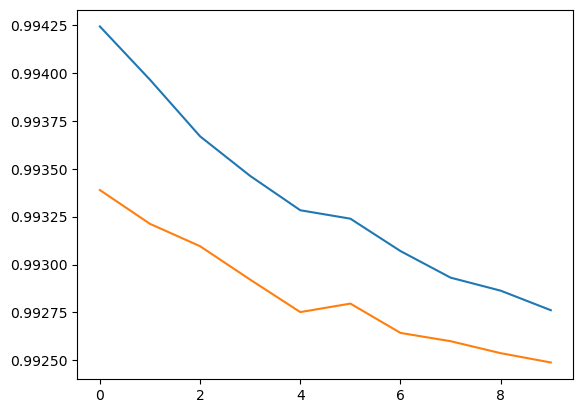

In [28]:
plt.plot(all_train_losses)
plt.plot(all_val_losses)

In [ ]:
import numpy as np
from PIL import Image

# let's take a random training example
idx = 10

# load image
image = train_dataset[idx]["image"]
image

In [30]:
# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(train_dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


In [31]:
model.eval()

# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)
     

In [32]:
# apply sigmoid
seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
seg_prob = seg_prob.cpu().numpy().squeeze()
seg = (seg_prob > 0.5).astype(np.uint8)
     

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(seg, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

The model is beginning to recognize rough edges around tools and the pelvis, but not accurate enough. Some possible strategies to improve:
1) Using a larger dataset (this may have the highest impact) <br>
2) Training for longer <br>
3) Experimenting with other sam models <br>

In [ ]:
fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(ground_truth_mask, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

### Metrics 

In [35]:
from torchmetrics.classification import BinaryJaccardIndex

In [36]:
jaccard = BinaryJaccardIndex()
jaccard = (seg, ground_truth_mask)

In [38]:
mean_jaccard = np.mean(jaccard[0])
accuracy = mean_jaccard * 100